In [1]:
import datetime
import pandas as pd
from matplotlib import pyplot as plt

import warnings #  for avoid unwanted warnings
warnings.filterwarnings('ignore')
 
data = pd.read_csv('AirPassengers.csv')
print(data.head())

     Month  #Passengers
0  1949-01          112
1  1949-02          118
2  1949-03          132
3  1949-04          129
4  1949-05          121


In [2]:
data.shape

(144, 2)

In [3]:
dateparse = lambda dates: datetime.datetime.strptime(dates, '%Y-%m')

data = pd.read_csv('AirPassengers.csv', parse_dates=['Month'], index_col='Month',date_parser=dateparse)
data

,#Passengers
Month,
1949-01-01,112
1949-02-01,118
1949-03-01,132
1949-04-01,129
1949-05-01,121
...,...
1960-08-01,606
1960-09-01,508
1960-10-01,461


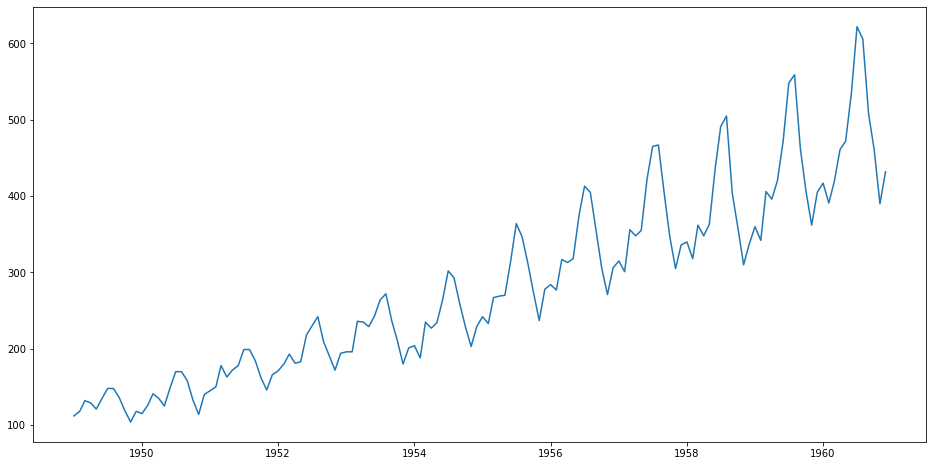

In [4]:
plt.figure(figsize=(16,8))
plt.plot(data)

In [5]:
from statsmodels.tsa.stattools import adfuller
def test_stationarity(timeseries):
    
    #Determing rolling statistics
    rolmean = timeseries.rolling(12).mean()
    rolstd = timeseries.rolling(12).std()

    #Plot rolling statistics:
    plt.figure(figsize=(16,8))
    orig = plt.plot(timeseries, color='blue',label='Original')
    mean = plt.plot(rolmean, color='red', label='Rolling Mean')
    std = plt.plot(rolstd, color='black', label = 'Rolling Std')
    plt.legend(loc='best')
    plt.title('Rolling Mean & Standard Deviation')
    plt.show(block=False)
    
    #Perform Dickey-Fuller test:
    print('Results of Dickey-Fuller Test:')
    dftest = adfuller(timeseries, autolag='AIC')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)'%key] = value
    print(dfoutput)

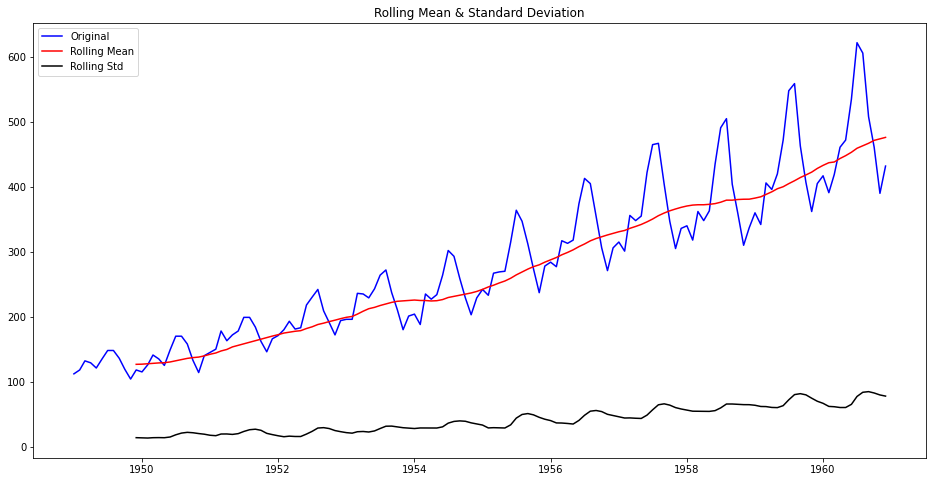

Results of Dickey-Fuller Test:
Test Statistic                   0.815369
p-value                          0.991880
#Lags Used                      13.000000
Number of Observations Used    130.000000
Critical Value (1%)             -3.481682
Critical Value (5%)             -2.884042
Critical Value (10%)            -2.578770
dtype: float64


In [6]:
test_stationarity(data.iloc[:,0])

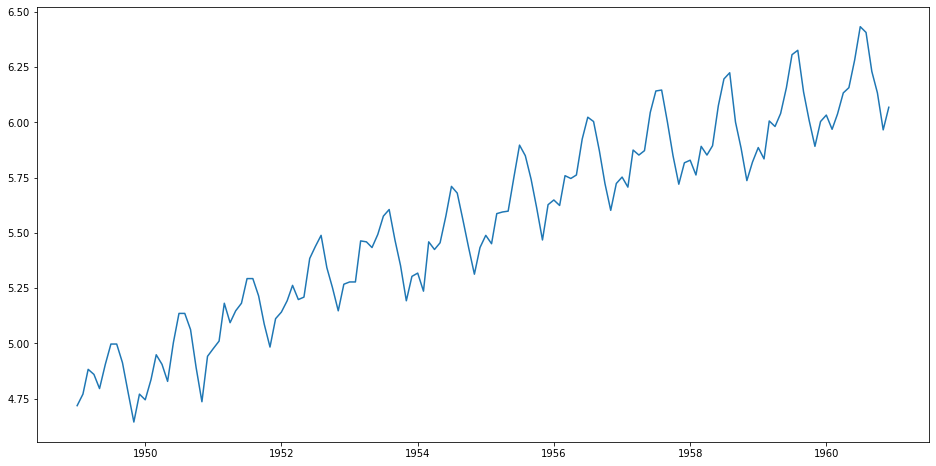

In [7]:
import numpy as np
ts_log = np.log(data)
plt.figure(figsize=(16,8))
plt.plot(ts_log)

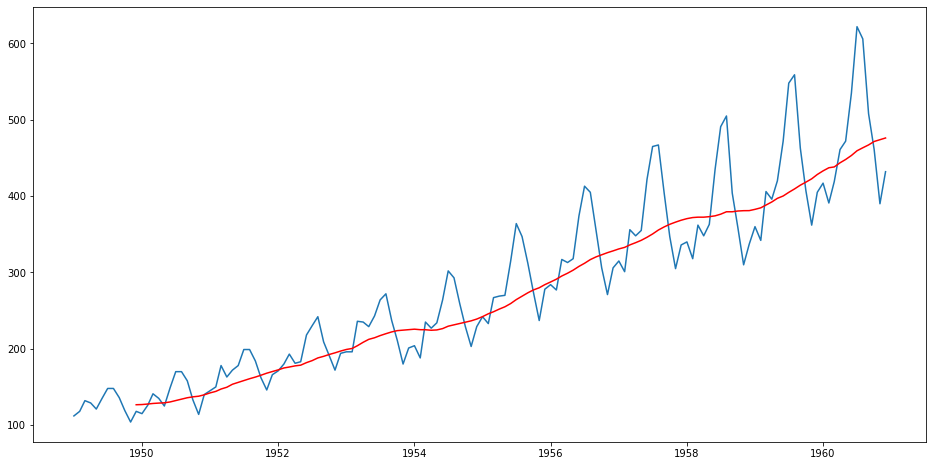

In [8]:
moving_avg = data.rolling(12).mean()
plt.figure(figsize=(16,8))
plt.plot(data)
plt.plot(moving_avg, color='red')

In [9]:
ts_log_moving_avg_diff = data - moving_avg
ts_log_moving_avg_diff.head(12)

,#Passengers
Month,
1949-01-01,NaN
1949-02-01,NaN
1949-03-01,NaN
1949-04-01,NaN
1949-05-01,NaN
1949-06-01,NaN
1949-07-01,NaN
1949-08-01,NaN
1949-09-01,NaN


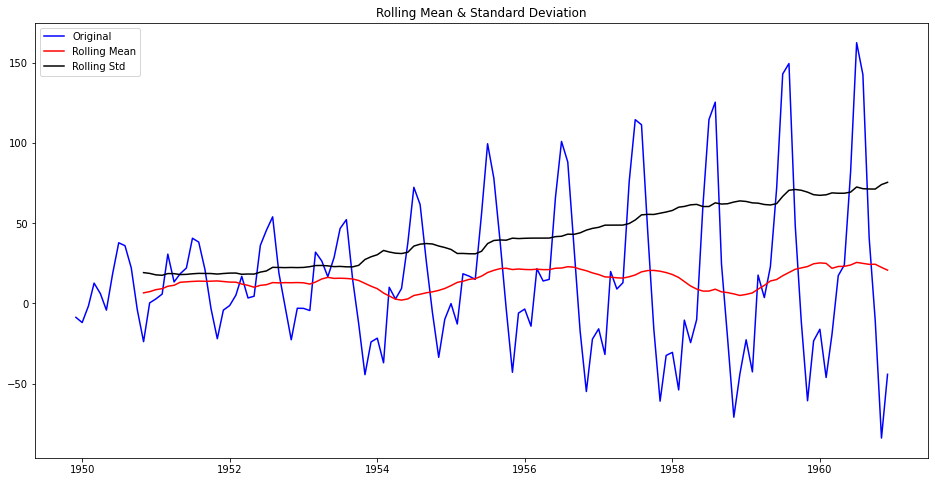

Results of Dickey-Fuller Test:
Test Statistic                  -3.164968
p-value                          0.022104
#Lags Used                      13.000000
Number of Observations Used    119.000000
Critical Value (1%)             -3.486535
Critical Value (5%)             -2.886151
Critical Value (10%)            -2.579896
dtype: float64


In [10]:
ts_log_moving_avg_diff.dropna(inplace=True)
test_stationarity(ts_log_moving_avg_diff.iloc[:,0])

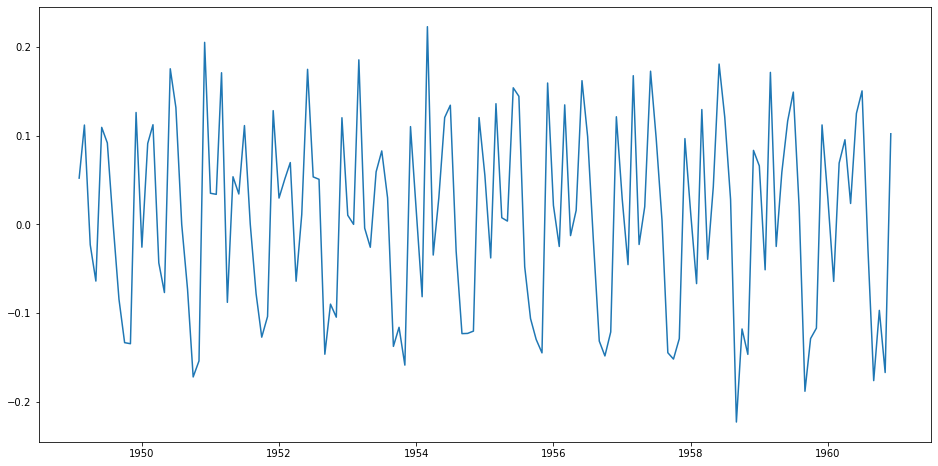

In [11]:
ts_log_diff = ts_log - ts_log.shift() # Shift index by desired number of periods with an optional time freq. This function takes a scalar parameter called the period, which represents the number of shifts to be made over the desired axis. This function is very helpful when dealing with time-series data.
plt.figure(figsize=(16,8))
plt.plot(ts_log_diff)

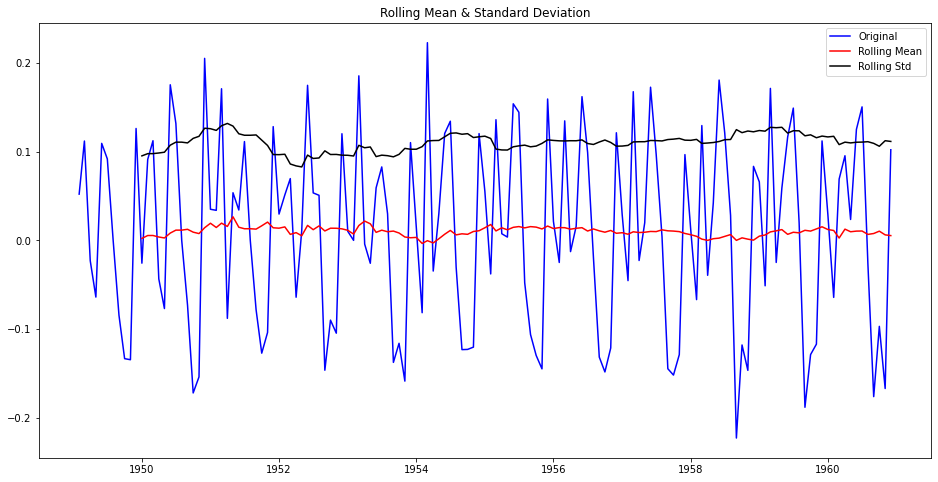

Results of Dickey-Fuller Test:
Test Statistic                  -2.717131
p-value                          0.071121
#Lags Used                      14.000000
Number of Observations Used    128.000000
Critical Value (1%)             -3.482501
Critical Value (5%)             -2.884398
Critical Value (10%)            -2.578960
dtype: float64


In [12]:
ts_log_diff.dropna(inplace=True)
test_stationarity(ts_log_diff.iloc[:,0])

# ACF
#### ACF is an (complete) auto-correlation function which gives us values of auto-correlation of any series with its lagged values. We plot these values along with the confidence band and tada! We have an ACF plot. In simple terms, it describes how well the present value of the series is related with its past values. A time series can have components like trend, seasonality, cyclic and residual. ACF considers all these components while finding correlations hence it’s a ‘complete auto-correlation plot’.

# PACF
#### PACF is a partial auto-correlation function. Basically instead of finding correlations of present with lags like ACF, it finds correlation of the residuals (which remains after removing the effects which are already explained by the earlier lag(s)) with the next lag value hence ‘partial’ and not ‘complete’ as we remove already found variations before we find the next correlation. So if there is any hidden information in the residual which can be modeled by the next lag, we might get a good correlation and we will keep that next lag as a feature while modeling. Remember while modeling we don’t want to keep too many features which are correlated as that can create multicollinearity issues. Hence we need to retain only the relevant features.

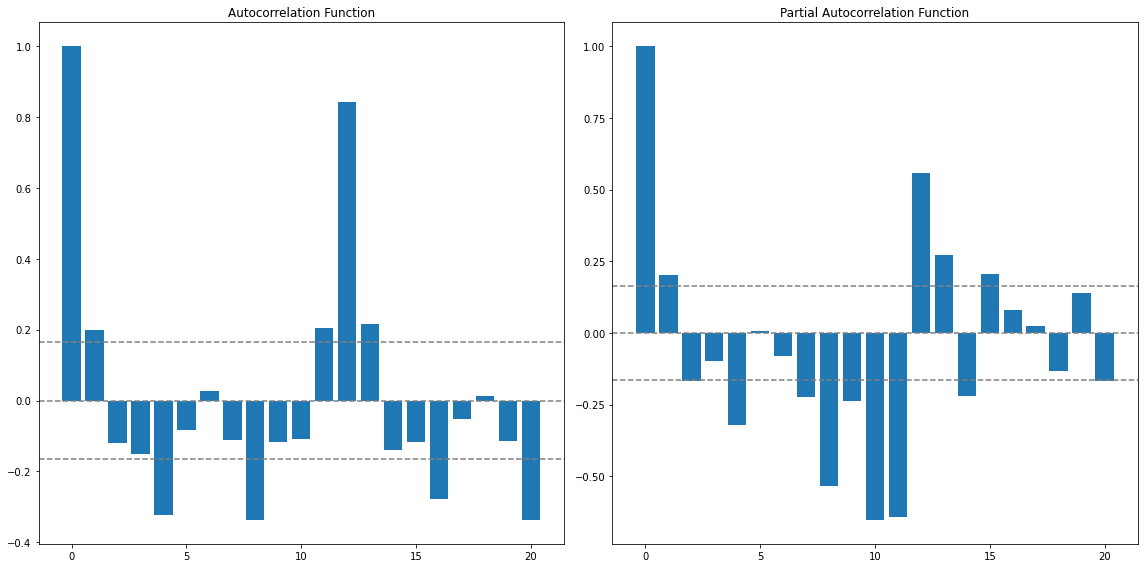

In [13]:
from statsmodels.tsa.stattools import acf, pacf

lag_acf = acf(ts_log_diff, nlags=20)
lag_pacf = pacf(ts_log_diff, nlags=20)
plt.figure(figsize=(16,8))
lags = np.array([i for i in range(21)])
#Plot ACF: 
plt.subplot(121) 
plt.bar(lags, lag_acf)
plt.axhline(y=0,linestyle='--',color='gray')
plt.axhline(y=-1.96/np.sqrt(len(ts_log_diff)),linestyle='--',color='gray')
plt.axhline(y=1.96/np.sqrt(len(ts_log_diff)),linestyle='--',color='gray')
plt.title('Autocorrelation Function')

#Plot PACF:
plt.subplot(122)
plt.bar(lags, lag_pacf)
plt.axhline(y=0,linestyle='--',color='gray')
plt.axhline(y=-1.96/np.sqrt(len(ts_log_diff)),linestyle='--',color='gray')
plt.axhline(y=1.96/np.sqrt(len(ts_log_diff)),linestyle='--',color='gray')
plt.title('Partial Autocorrelation Function')
plt.tight_layout()

C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'


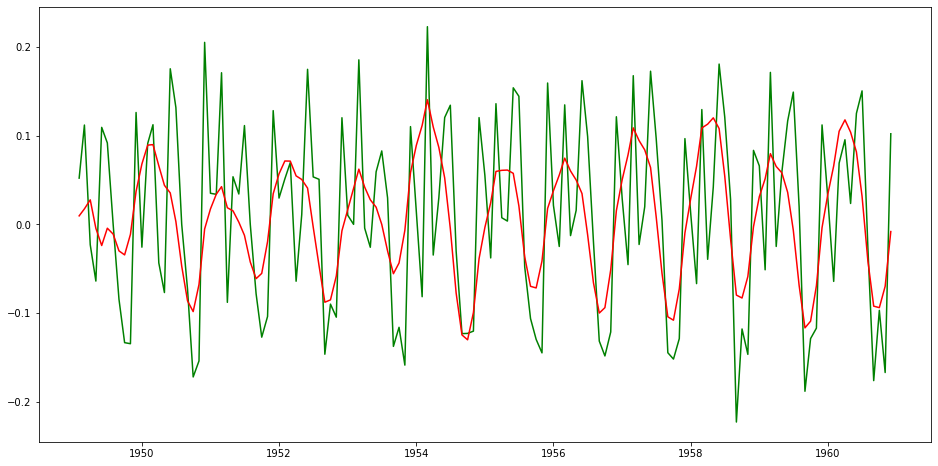

In [14]:
from statsmodels.tsa.arima_model import ARIMA


model = ARIMA(ts_log, order=(2, 1, 2))  
results_ARIMA = model.fit()  
plt.figure(figsize=(16,8))
plt.plot(ts_log_diff,color='green')
plt.plot(results_ARIMA.fittedvalues, color='red')
plt.show()

In [15]:
predictions_ARIMA_diff = pd.Series(results_ARIMA.fittedvalues, copy=True)
print(predictions_ARIMA_diff.head())

Month
1949-02-01    0.009580
1949-03-01    0.017491
1949-04-01    0.027670
1949-05-01   -0.004521
1949-06-01   -0.023890
dtype: float64


In [16]:
predictions_ARIMA_diff_cumsum = predictions_ARIMA_diff.cumsum()
print(predictions_ARIMA_diff_cumsum.head())

Month
1949-02-01    0.009580
1949-03-01    0.027071
1949-04-01    0.054742
1949-05-01    0.050221
1949-06-01    0.026331
dtype: float64


In [17]:
predictions_ARIMA_log = pd.Series(ts_log.iloc[0,0], index=ts_log.index)
predictions_ARIMA_log = predictions_ARIMA_log.add(predictions_ARIMA_diff_cumsum,fill_value=0)
predictions_ARIMA_log.head()

Month
1949-01-01    4.718499
1949-02-01    4.728079
1949-03-01    4.745570
1949-04-01    4.773241
1949-05-01    4.768720
dtype: float64

Text(0.5, 1.0, 'RMSE: 90.1043')

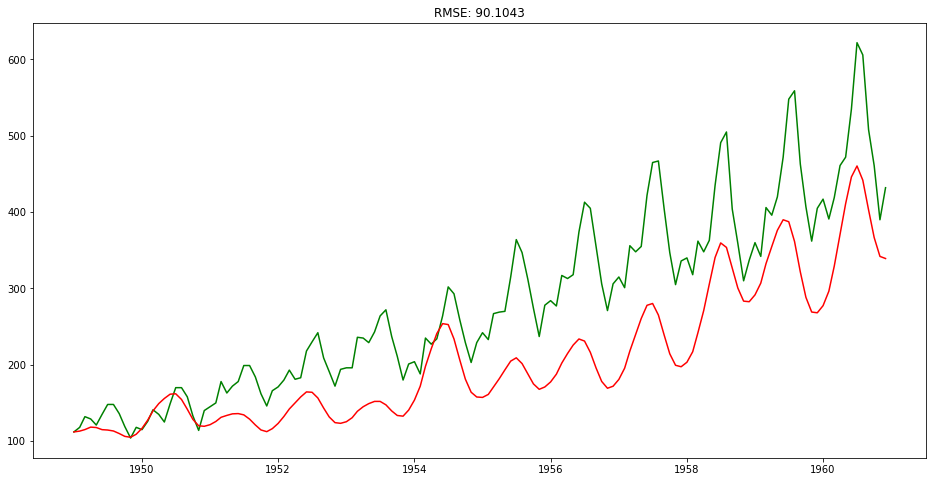

In [18]:
predictions_ARIMA = np.exp(predictions_ARIMA_log)
plt.figure(figsize=(16,8))
plt.plot(data.iloc[:,0],color='green')
plt.plot(predictions_ARIMA,color='red')
plt.title('RMSE: %.4f'% np.sqrt(sum((predictions_ARIMA-data.iloc[:,0])**2)/len(data)))

In [19]:
# ! pip install pyramid-arima (don't run)
# ! pip install pmd-arima (don't run)

In [20]:
# ! pip install pmdarima #(run this)

In [21]:
# from pyramid.arima import auto_arima
from pmdarima.arima import auto_arima

In [22]:
stepwise_model = auto_arima(data, start_p=1, start_q=1,
                               max_p=5, max_q=5, m=1,
                               seasonal=True,
                               d=None, max_d=3, trace=True,  
                               suppress_warnings=True,error_action="ignore", 
                               stepwise=True)# default parameters to ARIMA
stepwise_model.fit(ts_log)

Performing stepwise search to minimize aic
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=1396.121, Time=0.09 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=1415.278, Time=0.01 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=1403.473, Time=0.04 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=1398.827, Time=0.05 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=1413.909, Time=0.01 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.16 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.10 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=1398.386, Time=0.07 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=1397.975, Time=0.04 sec
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.24 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=1394.683, Time=0.04 sec
 ARIMA(0,1,1)(0,0,0)[0]             : AIC=1397.258, Time=0.02 sec
 ARIMA(1,1,0)(0,0,0)[0]             : AIC=1401.852, Time=0.02 sec
 ARIMA(2,1,1)(0,0,0)[0]             : AIC=1378.338, Time=0.06 sec
 ARIMA(2,1,0)(0,0,0)[0]             : AIC=1396.5

ARIMA(order=(4, 1, 3), scoring_args={}, suppress_warnings=True,
      with_intercept=False)

In [23]:
stepwise_model.predict(n_periods=12)

array([6.15666538, 6.14871936, 6.21050655, 6.22446867, 6.15041255,
       6.17266854, 6.18048123, 6.12020328, 6.15930333, 6.18297376,
       6.13123619, 6.16880363])

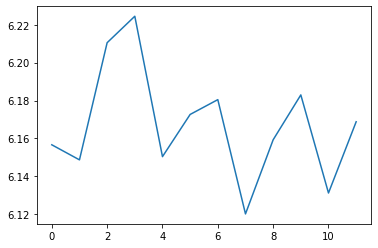

In [24]:
plt.plot(stepwise_model.predict(n_periods=12))